<a href="https://colab.research.google.com/github/jeff-ai-ml/genai-langgraph/blob/main/Clean_RAG_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install dependencies
!pip install -q langchain langgraph openai langchain_openai langchain-community langchain-chroma pypdf


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 71.9 MB/s eta 0:0

In [2]:
# -----------------------------
# 1. Imports & Setup
# -----------------------------
import os
from typing import TypedDict, Annotated, Sequence
from operator import add as add_messages

from google.colab import userdata
from dotenv import load_dotenv

# LangGraph / LangChain imports
from langgraph.graph import StateGraph, END
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma

from IPython.display import Image, display

In [3]:
# -----------------------------
# 2. LLM & Embeddings
# -----------------------------
llm = ChatOpenAI(
    model="gpt-4o-mini",
    api_key=userdata.get("OPENAI_API_KEY"),
    temperature=0  # deterministic, less hallucination
)

embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small",
    api_key=userdata.get("OPENAI_API_KEY")
)

In [5]:
# -----------------------------
# 3. Load PDF & Build Vectorstore
# -----------------------------
pdf_path = "Stock_Market_Performance_2024.pdf"
if not os.path.exists(pdf_path):
    raise FileNotFoundError(f"PDF file not found: {pdf_path}")

pdf_loader = PyPDFLoader(pdf_path)
pages = pdf_loader.load()
print(f"✅ PDF loaded with {len(pages)} pages")

# Chunk text
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
docs = splitter.split_documents(pages)

persist_dir = "stock_market_db"
os.makedirs(persist_dir, exist_ok=True)

vectorstore = Chroma.from_documents(
    documents=docs,
    embedding=embeddings,
    persist_directory=persist_dir,
    collection_name="stock_market"
)
print("✅ ChromaDB vector store created")

retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 5})


✅ PDF loaded with 9 pages
✅ ChromaDB vector store created


In [6]:
# -----------------------------
# 4. Define Tool
# -----------------------------
@tool
def retriever_tool(query: str) -> str:
    """Search the Stock Market Performance 2024 document for relevant info."""
    docs = retriever.invoke(query)
    if not docs:
        return "No relevant info found in the Stock Market 2024 document."
    return "\n\n".join([f"Chunk {i+1}:\n{doc.page_content}" for i, doc in enumerate(docs)])

tools = [retriever_tool]
llm = llm.bind_tools(tools)   # connect tools to LLM
tools_dict = {tool.name: tool for tool in tools}

In [7]:
# -----------------------------
# 5. LangGraph State
# -----------------------------
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

def should_continue(state: AgentState):
    """Check if the LLM requested a tool call."""
    last = state["messages"][-1]
    return hasattr(last, "tool_calls") and len(last.tool_calls) > 0

system_prompt = """
You are an AI assistant answering questions about Stock Market Performance in 2024.
- Use the retriever tool to search the document.
- Always cite chunks you use.
- Be precise and avoid hallucination.
"""


In [8]:
# -----------------------------
# 6. Node Functions
# -----------------------------
def query_llm(state: AgentState) -> AgentState:
    """Ask LLM what to do next (answer or call tool)."""
    messages = [SystemMessage(content=system_prompt)] + list(state["messages"])
    response = llm.invoke(messages)
    return {"messages": [response]}

def use_retriever(state: AgentState) -> AgentState:
    """Run retriever tool if LLM requested it."""
    tool_calls = state["messages"][-1].tool_calls
    results = []
    for call in tool_calls:
        tool_name, query = call["name"], call["args"].get("query", "")
        print(f"🔧 Running Tool: {tool_name} | Query: {query}")
        if tool_name not in tools_dict:
            result = f"❌ Tool {tool_name} not found."
        else:
            result = tools_dict[tool_name].invoke(query)
        results.append(ToolMessage(tool_call_id=call["id"], name=tool_name, content=result))
    return {"messages": results}


In [9]:
# -----------------------------
# 7. Build Graph
# -----------------------------
graph = StateGraph(AgentState)
graph.add_node("Query LLM", query_llm)
graph.add_node("Use Retriever Tool", use_retriever)

graph.add_conditional_edges(
    "Query LLM",
    should_continue,
    {True: "Use Retriever Tool", False: END}
)
graph.add_edge("Use Retriever Tool", "Query LLM")
graph.set_entry_point("Query LLM")

rag_agent = graph.compile()

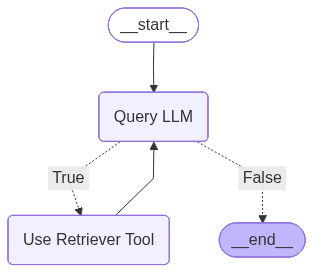

In [10]:
# -----------------------------
# 8. Visualize Graph
# -----------------------------
display(Image(rag_agent.get_graph().draw_mermaid_png()))

In [11]:
# -----------------------------
# 9. Run Interactive Agent
# -----------------------------
def run_agent():
    print("\n=== Stock Market RAG Agent ===")
    while True:
        q = input("\nAsk your question (or type exit): ")
        if q.lower() in ["exit", "quit"]:
            break
        messages = [HumanMessage(content=q)]
        result = rag_agent.invoke({"messages": messages})
        print("\n=== ANSWER ===")
        print(result["messages"][-1].content)

run_agent()


=== Stock Market RAG Agent ===

Ask your question (or type exit): Which is the best stock of 2024?
🔧 Running Tool: retriever_tool | Query: best stock of 2024

=== ANSWER ===
The best-performing stock of 2024 was Palantir Technologies (PLTR), which saw its stock price soar by about 340% throughout the year. This remarkable increase was attributed to the company's first profitable quarters and its positioning as a key player in artificial intelligence for both government and enterprise sectors. Palantir's share price climbed from single-digit levels to the mid-$20s by the end of 2024, reflecting a significant turnaround in investor sentiment and excitement over its AI platforms (Chunk 3). 

Additionally, the technology sector overall had a stellar year, with the S&P 500 gaining roughly 25%, driven by strong performances from major companies like Apple, Alphabet, and Meta, as well as high-growth tech startups (Chunk 2).

Ask your question (or type exit): list the companies given in the d